<a href="https://colab.research.google.com/github/hannape/IBAC-Biodiv/blob/master/project2_moje_zmiany_train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Funkcje Pomocnicze do Zadania

Aby wszystkie funkcje zadziałały, notebook powinien być uruchamiany z następującym ułożeniem katalogów:

```
|- helpers.ipynb
|- sampleSubmission.csv
|- train
 |- {unzipped train files and labels}
|- test
 |- {unzipped test files}
```

Należy odkomentować u siebie linijki zapisujące pliki.

Projekt 2, na razie na treningu z zadania z kaggla, na teście moim z 20 nagrań testowych. Trzeba przerobić zbiór testowy i reprezentacje.

In [0]:
import os

import librosa
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import roc_auc_score
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn import preprocessing
import wave
import contextlib
import math

In [0]:
from google.colab import drive
drive.mount('/content/drive')
from __future__ import print_function

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Wczytywanie Danych

Poniższe funkcje są przykładowymi funkcjami wczytującymi dane. Możliwe, że będą potrzebne modyfikacje reprezentacji i bardziej skomplikowana funkcja tworząca zbiór treningowy. Wczytywanie danych nie jest zaimplementowane optymalnie - między innymi kod wczytuje wielokrotnie ten sam plik. Dla bardziej złożonych reprezentacji możliwe, że trzeba będzie przepisać te funkcje.

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')
#from __future__ import print_function
###########################Dodatkowe, do innego wczytywania nagrań, i innego zapisu predykcji. Do stworzenia testowego 
  
path_test1618 = 'drive/My Drive/testowe_1618/'

def my_load_mel(samples, start=0, stop=None ):
    '''Wczytuje mel spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
        n_mels (int): Liczba meli na spektrogramie (wysokość spektrogramu).
    
    Returns:
        ndarray: Spektrogram.
    '''
    sample_rate = 44100
    n_mels= 60 ## -------------------------------------------------------------------- ZMIANA ze 128
    #samples, sample_rate = librosa.core.load(file_name, sr = None)
   
    #samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    if(stop>np.shape(samples)[0]):
      #print(stop)
      #print(stop-start)
      stop = np.shape(samples)[0]
      print("TUTEEEEEEEEEEJ")
      #print(stop-start)
      print((stop-start)/sample_rate)
    #samples = samples[int(start):int(stop)] # if stop<np.shape(samples)[0] else int(start):np.shape(samples)[0]]
    
    samples = samples[int(start):int(stop) if stop else None]
    #print(np.shape(samples)[0])
    #print(sample_rate/2)
    #if np.shape(samples[0])<sample_rate:
    #print("rozmiar 0.5sek probki" + str(np.shape(samples)[0]))
    if(np.shape(samples)[0] < sample_rate/2):
      print("weszło w warunek")
      diff = sample_rate/2 - np.shape(samples)[0]
      samples = np.pad(samples, (0,int(diff)), 'constant', constant_values=(0))
      print(np.shape(samples)[0])
      print("PADY" + str(start)+ " , " + str(stop))
    ''' 
    samples_float = librosa.util.buf_to_float(samples,n_bytes=2,dtype=np.float32)  
    stft = librosa.stft(np.array(samples_float), n_fft=512, win_length=512, hop_length= 150,    window="hann")

    # Compute squared magnitude coefficients.
    abs2_stft = (stft.real*stft.real) + (stft.imag*stft.imag)
    result3 = librosa.feature.melspectrogram(y=None, S=abs2_stft, sr=44100, n_mels= 60, fmin = 4000, fmax=9500, hop_length=512, n_fft=512)  
     
    spectrogram = librosa.feature.melspectrogram(y = samples, sr = sample_rate,
                                                   n_mels = n_mels, fmin = 4000, fmax = 9500) '''
    spectrogram = librosa.feature.melspectrogram(y = samples, sr = sample_rate, n_fft=512, hop_length = 150,
                                                   n_mels = n_mels, fmin = 4000, fmax = 9500)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    #print(np.shape(spectrogram))
    return spectrogram


def my_check_voices(second, labels, tol=0.):
    '''Sprawdza czy w ramce czasowej [second, second+1] znajduje się głos według etykiet `labels`.
    
    Args:
        second (float): Sekunda nagrania.
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
        tol (float): Tolerancja na brzegach fragmentu. Dźwięk, żeby był uznany, musi się kończyć po czasie `second+tol`
            lub zaczynać przed czasem `second+1-tol`.
    Returns:
        bool: Czy w ramce czasowej jest odgłos ptaka.
    
    
    if(float(labels[0]) >= second and float(labels[0]) < second + 1 - tol) or \
           (float(labels[1]) < second + 1 and float(labels[1]) > second + tol) or \
           (float(labels[0]) < second and float(labels[1]) > second + 1):
            print("def my_check_voices") 
            print(second)
     
    calls_to_cut = ['t', 't?', 't ','t  ', 'g', 'czapla', 'gh', 'g cz', 'puszczyk','gaski','g?','mewa?','zwierzak?','high freq','g niskie','??? mysz']
    if ((float(labels[0]) >= second and float(labels[0]) < second + 1 - tol) or \
           (float(labels[1]) < second + 1 and float(labels[1]) > second + tol) or \
           (float(labels[0]) < second and float(labels[1]) > second + 1)) and (labels[2] in calls_to_cut): 
      #y_read[~y_read['bird'].isin(calls_to_cut)]
      print(second,labels[2])''' 
    
    calls_to_cut = ['t', 't?', 't ','t  ', 'g', 'czapla', 'gh', 'g cz', 'puszczyk','gaski','g?','mewa?','zwierzak?','high freq','g niskie','??? mysz']
    
    return (float(labels[0]) >= second and float(labels[0]) < second + 0.5 - tol) or \
           (float(labels[1]) < second + 0.5 and float(labels[1]) > second + tol) or \
           (float(labels[0]) < second and float(labels[1]) > second + 0.5) and (labels[2] in calls_to_cut)


def my_read_labels(label_name,path_test1618):
    '''Wczytuje etykiety czasowe z pliku labels.txt w folderze train.
    
    Returns:
        ndarray: Tablica z etykietami czasowymi zawierająca kolumny: nr nagrania, sekunda początku dźwięku, sekunda końca dźwięku.
    '''
    labels = []
    with open(os.path.join(path_test1618, label_name + '.txt'), 'r') as file:
        text = file.read()
        for line in text.split('\n')[0:]:
            if len(line) > 1:
                start, stop, spec = line.split('\t')
                #print(start)
                start, stop, spec = float(start), float(stop), str(spec),
                labels.append([start, stop, spec])
    return np.array(labels)

  
def my_map_seconds_to_y(labels, recording_duration):  ## Chcemy 500 ms z 150 ms overlapem
    '''Tworzy etykiety dla każdej kolejnej sekundy 10-sekundowego nagrania. -1 oznacza niepewną etykietę (urwane dźwięki na brzegach).
    
    Args:
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
    Returns:
        ndarray: Tablica z binarnymi etykietami dla każdej z 10 sekund z możliwą niepewną etkietą -1.
    '''
    calls_to_cut = ['t', 't?', 't ','t  ', 'g', 'czapla', 'gh', 'g cz', 'puszczyk','gaski','g?','mewa?','zwierzak?','high freq','g niskie','??? mysz']
    
    
    chunk_length_ms = 500
    chunk_overlap = 150
    duration_in_ms = recording_duration*1000
    nr_of_chunks =  1 + (duration_in_ms - chunk_length_ms) / (chunk_length_ms - chunk_overlap)
    print("chunksy!!")
    print(nr_of_chunks)
    #frame_start = i*(chunk_length_ms - chunk_overlap)
    #frame_end = i*(chunk_length_ms - chunk_overlap)+ chunk_length_ms
    
    
    y = [0] * math.ceil(nr_of_chunks) #recording_duration 
    y_restrictive = [0] * math.ceil(nr_of_chunks) #* recording_duration
    for s in range(math.ceil(nr_of_chunks)):
        for l in labels:
            if my_check_voices(s*0.35, l):
                y[s] = 1
                #print(s*0.35)
                if l[2] in calls_to_cut:
                  y[s] = 0
                 # print("Labele1: " + l[2]) 
            if my_check_voices(s*0.35, l, 0.004): # 0.02
                y_restrictive[s] = 1
                if l[2] in calls_to_cut:
                  y_restrictive[s] = 0
                  print("wyciety glos:")
                  print(l[2])
                  
                 # print("Labele2: " + l[2]) 
        if y[s] != y_restrictive[s]:
            y[s] = 0 # -1 jeśli mniej niż 4 ms fragment, to zakładamy że tam go nie ma...          
        
    #print("Labele dla nagrania: " + str(y))        
    return y
  
  
def my_load_test(a, load_repr=my_load_mel):
    '''Wczytuje dane testowe, moje, długie nagrania.

    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.

    Returns:
        (ndarray, ndarray): Tablica z danymi treningowymi, tablica z binarnymi etykietami treningowymi.
    '''
    
    
    X_train, y_train = [], []
    samples, sample_rate2 = [], []
    rec_files = [file_name for file_name in sorted(os.listdir(path_test1618)) if file_name.endswith('.wav')]
    print(rec_files)

    for file_name in rec_files[a:a+10]: # range(0,3):#

        recording_id = (file_name.split('.')[0])
        print("------------Analiza nagrania: " + file_name + "-----------")
        fname = path_test1618 + file_name
        with contextlib.closing(wave.open(fname,'r')) as f:
            frames = f.getnframes()
            rate = f.getframerate()
            duration = frames / float(rate)
            recording_duration = math.ceil(duration)
            print("Czas trwania - w sekundach: " + str(recording_duration))
        
        #recording_labels = labels[labels[:, 0] == recording_id]
        print("Przed my read labels")
        recording_labels = my_read_labels(recording_id,path_test1618)
        print("Przed my map seconds to y")
        print(np.shape(recording_labels))
        y_binary = my_map_seconds_to_y(recording_labels, duration)
        print("Po my map seconds to y")
        
       # print(np.shape(y_binary))
       # print("+++++++++++++++")
       # print(fname)
       # print("+++++++++++++++")
        
        samples, sample_rate2 = librosa.core.load(fname, sr = None)
        print("SAMPLE")
        print(np.shape(samples))
        print(np.shape(y_binary))
        for i, y in enumerate(y_binary):
            if y != -1:
                try:
                    # print(i*15435/44100, (i*15435 + 22050)/44100)
                    representation = load_repr(samples, start = i*15435 , stop = i*15435 + 22050)# start = i, stop = i + 1)
                    if (i%1000==0):
                      #print(i)
                      #print(i*0.35)
                      end_time = datetime.datetime.now()
                      print(end_time - start_time)
                      print(np.shape(X_train),np.shape(y_train))
                      start_time == end_time
                    X_train.append(representation)
                    y_train.append(y)
                except ValueError:
                    print('Error reading file', file_name)
                except TypeError:
                    print('Unsupported type', file_name)
        print(np.shape(X_train),np.shape(y_train))  
        
    return np.array(X_train), np.array(y_train)

In [0]:
rec_files = [file_name for file_name in sorted(os.listdir(path_test1618)) if file_name.endswith('.wav')]
print(rec_files[0:3])


['BUK1_20180918$040704.wav', 'BUK1_20181011$001004.wav', 'BUK1_20181013$023504.wav']


In [0]:
## do traina



def load_mel(file_name, start=0, stop=None, n_mels=128):
    '''Wczytuje mel spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
        n_mels (int): Liczba meli na spektrogramie (wysokość spektrogramu).
    
    Returns:
        ndarray: Spektrogram.
    '''
    samples, sample_rate = librosa.core.load(file_name, sr = None)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    spectrogram = librosa.feature.melspectrogram(y = samples, sr = sample_rate,
                                                 n_mels = n_mels, fmin = 4000, fmax = 9500)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    #print(np.shape(spectrogram))
    return spectrogram


def load_spec(file_name, start=0, stop=None):
    '''Wczytuje standardowy spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
    
    Returns:
        ndarray: Spektrogram.
    '''
    sample_rate, samples = wavfile.read(file_name)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    _, _, spectrogram = signal.spectrogram(samples, sample_rate)
    return spectrogram


def load_test(load_repr=load_mel):
    '''Wczytuje dane testowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        ndarray: Tablica z danymi testowymi.
    '''
    with open('drive/My Drive/top2/sampleSubmission.csv', 'r') as file:
        lines = file.read().split()[1:]
        sample_ids = [line.split(',')[0] for line in lines]
        samples = np.array([s.split('/') for s in sample_ids])
    
    X_test = []
    rec_files = sorted([file_name for file_name in os.listdir('drive/My Drive/test') 
                        if file_name.endswith('.wav')], key=lambda x: int(x.split('.')[0][3:]))
    for file_name in rec_files:
        recording_id = file_name.split('.')[0][3:]
        time_markers = samples[samples[:, 0] == recording_id, 1].astype(np.int)
        for t in time_markers:
            representation = load_repr(os.path.join('drive/My Drive/test', file_name), start = t, stop = t + 1)
            X_test.append(representation)
    return np.array(X_test)


def read_labels():
    '''Wczytuje etykiety czasowe z pliku labels.txt w folderze train.
    
    Returns:
        ndarray: Tablica z etykietami czasowymi zawierająca kolumny: nr nagrania, sekunda początku dźwięku, sekunda końca dźwięku.
    '''
    labels = []
    with open(os.path.join('drive/My Drive/train', 'labels.txt'), 'r') as file:
        text = file.read()
        for line in text.split('\n')[1:]:
            if len(line) > 1:
                rec, start, stop = line.split(',')
                rec, start, stop = int(rec[3:]), float(start), float(stop)
                labels.append([rec, start, stop])
    return np.array(labels)


def check_voices(second, labels, tol=0.):
    '''Sprawdza czy w ramce czasowej [second, second+1] znajduje się głos według etykiet `labels`.
    
    Args:
        second (float): Sekunda nagrania.
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
        tol (float): Tolerancja na brzegach fragmentu. Dźwięk, żeby był uznany, musi się kończyć po czasie `second+tol`
            lub zaczynać przed czasem `second+1-tol`.
    Returns:
        bool: Czy w ramce czasowej jest odgłos ptaka.
    '''
    return (labels[1] >= second and labels[1] < second + 1 - tol) or \
           (labels[2] < second + 1 and labels[2] > second + tol) or \
           (labels[1] < second and labels[2] > second + 1)


def map_seconds_to_y(labels):
    '''Tworzy etykiety dla każdej kolejnej sekundy 10-sekundowego nagrania. -1 oznacza niepewną etykietę (urwane dźwięki na brzegach).
    
    Args:
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
    Returns:
        ndarray: Tablica z binarnymi etykietami dla każdej z 10 sekund z możliwą niepewną etkietą -1.
    '''
    y = [0] * 10
    y_restrictive = [0] * 10
    for s in range(10):
        for l in labels:
            if check_voices(s, l):
                y[s] = 1
            if check_voices(s, l, 0.02):
                y_restrictive[s] = 1
        if y[s] != y_restrictive[s]:
            y[s] = -1
    return y


def load_train(load_repr=my_load_mel):
    '''Wczytuje dane treningowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        (ndarray, ndarray): Tablica z danymi treningowymi, tablica z binarnymi etykietami treningowymi.
    '''
    path_train161718 = 'drive/My Drive/treningowe94_161718/'
    
    X_train, y_train = [], []
    
    rec_files = [file_name for file_name in os.listdir(path_train161718) if file_name.endswith('.wav')]
    years = ['2016','2017','2018']
    files_sorted = []

    for year in years:
      i_201x = [i for i,s in enumerate(rec_files) if year in s]
      n_201x = sorted(rec_files[index] for index in i_201x)
      files_sorted = files_sorted + n_201x
     
    rok = "6"
    for file_name in files_sorted:
       
        print("------------Analiza nagrania: " + file_name + "-----------")
        recording_id = str(file_name.split('.')[0])
        if (file_name=="BUK4_20171001_020404a.wav"):
          rok = "7"
        if (file_name=="BUK4_20181029_235604.wav"):
          rok = "8"  
        source_npz = "/content/drive/My Drive/nobirds_chunks/repr7_201" + rok + "/"
        ## wczytanie plików, skąd można wziąc nr próbek losowych do balanced dataset
        dane1 = np.load(source_npz + 'Kopia '+ recording_id + '_7rep.npz' )
        nobirds_chunks = dane1["nobirds_chunks"]
        #print(nobirds_chunks)  
        print(np.shape(nobirds_chunks)) 
        
        fname = path_train161718 + file_name
        with contextlib.closing(wave.open(fname,'r')) as f:
            frames = f.getnframes()
            rate = f.getframerate()
            duration = frames / float(rate)
            recording_duration = math.ceil(duration)
            print("Czas trwania - w sekundach: " + str(recording_duration))
            
      
      
        recording_id = (file_name.split('.')[0])
        print(recording_id)
        #print("Przed my read labels")
        recording_labels = my_read_labels(recording_id, path_train161718)
        #print("Przed my map seconds to y")
        #print(np.shape(recording_labels))
        y_binary = my_map_seconds_to_y(recording_labels, duration)
        #print("Po my map seconds to y")
        
        samples, sample_rate2 = librosa.core.load(fname, sr = None)
        
        for i, y in enumerate(y_binary):
            if y == 1:
                try:
                    representation = load_repr(samples, start = i*15435 , stop = i*15435 + 22050) #(os.path.join('drive/My Drive/treningowe94_161718', file_name), start = i, stop = i + 1)
                    X_train.append(representation)
                    y_train.append(y)
                    #print(i*0.35)
                except ValueError:
                    print('Error reading file', file_name)
                except TypeError:
                    print('Unsupported type', file_name)
        
        for i in nobirds_chunks:
            #if y == 1:
                try:
                    representation = load_repr(samples, start = i*15435 , stop = i*15435 + 22050) #(os.path.join('drive/My Drive/treningowe94_161718', file_name), start = i, stop = i + 1)
                    X_train.append(representation)
                    y_train.append(y)
                except ValueError:
                    print('Error reading file', file_name)
                except TypeError:
                    print('Unsupported type', file_name)
        print("Liczba no birds chunks: " + str(np.shape(nobirds_chunks)) + "Liczba positive chunks: " + str(sum(y_binary)))
        
        
        
        print(np.shape(X_train),np.shape(y_train)) 
    return np.array(X_train), np.array(y_train)
  
 ###


In [0]:
#@title
rec_files = [file_name for file_name in os.listdir('drive/My Drive/treningowe94_161718') if file_name.endswith('.wav')]
years = ['2016','2017','2018']
files_sorted = []

for year in years:
  i_201x = [i for i,s in enumerate(rec_files) if year in s]
  n_201x = sorted(rec_files[index] for index in i_201x)
  files_sorted = files_sorted + n_201x
  
print(files_sorted)
  


In [0]:
#@title
rec_files = [file_name for file_name in os.listdir('drive/My Drive/treningowe94_161718') if file_name.endswith('.wav')]
recording_id = rec_files[0]
recording_id = str(recording_id.split('.')[0])

source_npz = "/content/drive/My Drive/nobirds_chunks/repr7_2016/"
print(source_npz + 'Kopia '+ recording_id + '_7rep.npz')
a = '/content/drive/My Drive/nobirds_chunks/repr7_2016/Kopia BUK4_20161013_200104_7rep.npz'
print(a)
dane1 = np.load(source_npz + 'Kopia '+ recording_id + '_7rep.npz')
dane1 = np.load('/content/drive/My Drive/nobirds_chunks/repr7_2016/Kopia BUK4_20161013_200104_7rep.npz')

In [0]:
X_train_new, y_train_new = load_train()

print(X_train_new.shape)
print(y_train_new.shape)

------------Analiza nagrania: 1swierszcze_nakladki_BUK4_20160925_204604.wav-----------
(124,)
Czas trwania - w sekundach: 1799
1swierszcze_nakladki_BUK4_20160925_204604
chunksy!!
5136.721023647554
wyciety glos:
t
wyciety glos:
t
wyciety glos:
t
wyciety glos:
t?
wyciety glos:
t?
wyciety glos:
t?
wyciety glos:
t?
wyciety glos:
t
Liczba no birds chunks: (124,)Liczba positive chunks: 125
(249, 60, 148) (249,)
------------Analiza nagrania: 2koniec_swierszczy_BUK4_20160925_221604.wav-----------
(65,)
Czas trwania - w sekundach: 1799
2koniec_swierszczy_BUK4_20160925_221604
chunksy!!
5136.721023647554
wyciety glos:
puszczyk
wyciety glos:
puszczyk
wyciety glos:
puszczyk
Liczba no birds chunks: (65,)Liczba positive chunks: 66
(380, 60, 148) (380,)
------------Analiza nagrania: 3wzgledna_cisza_BUK4_20160925_224604.wav-----------
(110,)
Czas trwania - w sekundach: 1799
3wzgledna_cisza_BUK4_20160925_224604
chunksy!!
5136.721023647554
Liczba no birds chunks: (110,)Liczba positive chunks: 111
(601, 6

In [0]:
#@title
yyy = np.load('/content/drive/My Drive/rep IBAC/rep3V3/y_train_rep3V3.npy',allow_pickle=True)
print(yyy[0:380])

Funkcje dla mojego zbioru testowego 20 nagrań, dopasowane do zadania (1-s fragmenty).


Przygotowanie zbalansowanego treningu, taki jak wcześniej! powinno być 15,9k próbek.

Trzeba 
* odczytać które próbki były brane jako losowe w tamtym podejściu ibac (gdzie to było?)
* zmienić z 1 sekundy na 0,5 sek z overlapem 150ms
* coś zrobić z podzielonymi próbkami - wrócić do mojej opcji, jak zostaje mniej niż 4 ms to nei bierzemy jako głos. 
* podzielić tak samo na traina i walida
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.2, random_state=667)
* zmienić też trening - na razie dopasowany, 1s

In [0]:
#print(np.shape(y_test2))
#print(np.shape(y_test))
#y_test = np.concatenate((y_test, y_test2))
#X_test = np.concatenate((X_test, X_test2))
#print(np.shape(y_test))
#print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(X_train))
print(np.shape(y_val))
print(np.shape(X_val))

NameError: ignored

In [0]:
#np.savez('drive/My Drive/Xy_test_60x148', X_test=X_test,y_test=y_test)

KeyboardInterrupt: ignored

In [0]:
print(np.shape(X_test))
np.savez(path_test1618 + "testowe_1618", X_test=X_test,y_test=y_test)
Xtest =  np.load(path_test1618 + "testowe_1618.npz")
print(sum((Xtest["y_test"])==0))

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [0]:
with open('drive/My Drive/top2/sampleSubmission.csv', 'r') as file:
    lines = file.read().split()[1:]
    sample_ids = [line.split(',')[0] for line in lines]
    samples = np.array([s.split('/') for s in sample_ids])
    print(lines, sample_ids,samples)

In [0]:

#X_test = load_test()

In [0]:
#X_test, y_test = my_load_train()

print(X_test.shape)
print(y_test.shape)

(102715, 60, 148)
(102715,)


In [0]:
print(np.shape(y_train))
print(np.shape(X_train))
#X_train = X_train.numpy()
#y_train = y_train.numpy()
print(np.shape(y_train))
print(np.shape(X_train))
print(np.shape(y_valid))
print(np.shape(X_valid))

torch.Size([10185])
torch.Size([10185, 60, 148])
torch.Size([10185])
torch.Size([10185, 60, 148])
torch.Size([2547])
torch.Size([2547, 60, 148])


# Model i Trenowanie

Poniższy przykład używa poprawnych metryk i zapisuje parametry modelu.

In [0]:
# Dzielenie zbioru danych na treningowy i walidacyjny
#split_point = int(len(X) * 0.8)
import sklearn
X_train1, X_val1, y_train1, y_val1 = sklearn.model_selection.train_test_split(X_train_new, y_train_new, test_size=0.2, random_state=667)

X_train = torch.Tensor(X_train1) #X[:split_point])
y_train = torch.LongTensor(y_train1) #[:split_point])
print(np.shape(y_train))
print(np.shape(X_train))
X_valid = torch.Tensor(X_val1) #[split_point:])
y_valid = torch.LongTensor(y_val1) #[split_point:])
print(np.shape(y_valid))
print(np.shape(X_valid))
batch_size = 64

dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_data_loader = DataLoader(valid_dataset, batch_size = batch_size)

torch.Size([12732])
torch.Size([12732, 60, 148])
torch.Size([3184])
torch.Size([3184, 60, 148])


In [0]:
from torch import nn

# kopia architektury resnet z biblioteki pytorch (licencja cc) https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=2, zero_init_residual=False, # <<<<<<<<<<<<<<<<<<<< zmiana na 2 klasy
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)  # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< konwersja na 1 kanał
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)   # torch.flatten(x, 1)
        x = self.fc(x)

        return x

clf = ResNet(BasicBlock, [2, 2, 2, 2]).cuda()

In [0]:
import calendar;
import time;
ts = calendar.timegm(time.gmtime())

for run in range(5):
    losses, scores = [], []
    epoch = 0
    clf = ResNet(BasicBlock, [2, 2, 2, 2]).cuda()

    # Ustawienie kosztu i optimizera
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(clf.parameters())

    # Pętla uczenia
    best_preds, best_score = None, 0.
    batches = X_train.shape[0]//64
    torch.set_num_threads(55)

    for epoch in range(15):
        running_loss = 0
        clf.train()
        batch = 0
        for X, y in data_loader:
            X = X[:,None,:,:]
            batch = batch+1

            optimizer.zero_grad()

            outputs = clf(X.cuda())
            loss = criterion(outputs, y.cuda())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        losses.append(running_loss)

        clf.eval()
        preds = []
        for X, _ in valid_data_loader:
            X = X[:,None,:,:]
            out = clf(X.cuda())
            preds.append(torch.softmax(out, dim = 1)[:, 1].cpu().detach().numpy())
        preds = np.concatenate(preds, axis = 0)

        # Metryką testującą jest ROC AUC
        score = roc_auc_score(y_valid.numpy(), preds)
        scores.append(score)
        #print('Epoch:', epoch, 'Batch', batch+1, '/', batches, 'Score:', score, 'Loss', running_loss)
        if score > best_score:
            best_score = score
            best_preds = preds
            #np.save('tmp_preds', best_preds)

            # Model dający najlepszy wynik powinien być zapisany
            torch.save(clf.state_dict(), 'tmp_model.pt')
            
    print(run, "score", best_score)
    if best_score > 0.945:
        print('Saving')
        state = torch.load('tmp_model.pt')
        t = "drive/My Drive/models/top2-my-setup/" + str(ts)
        os.makedirs(t, exist_ok=True)
        torch.save(state, t + '/run_' + str(run) + '_' + str(best_score) + '.pt')

0 score 0.9611220736683849
Saving
1 score 0.9646080484384475
Saving
2 score 0.9656195516221953
Saving
3 score 0.9670894291995149
Saving
4 score 0.9620232274610875
Saving


Best score 0.9620232274610875


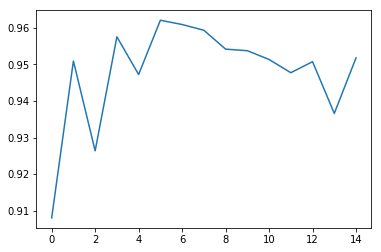

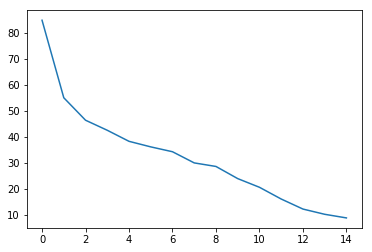

In [0]:
# Rysowanie lossu i AUC

import matplotlib.pyplot as plt

%matplotlib inline

print('Best score', best_score)

plt.plot(scores)
plt.show()

plt.plot(losses)
plt.show()

In [0]:
#clf.load_state_dict(torch.load('tmp_model.pt'))

#clf.load_state_dict(torch.load('./models/1558383876/run_5_0.9504516129032259.pt'))
#clf.load_state_dict(torch.load('drive/My Drive/models/top2/1570200649/run_0_0.9485496411483253.pt'))

#clf.load_state_dict(torch.load('drive/My Drive/top2/weights.pt'))
#clf.load_state_dict(torch.load('drive/My Drive/models/top2-my-setup/1570817696/run_0_0.999039032494441.pt'))
#clf.load_state_dict(torch.load('drive/My Drive/models/top2-my-setup/1570819105/run_0_0.9642908186148171.pt'))
clf.load_state_dict(torch.load('drive/My Drive/models/top2-my-setup/1570822353/run_3_0.9670894291995149.pt'))


<All keys matched successfully>

# Zapis Predykcji

In [0]:
import datetime
start_time = datetime.datetime.now()
X_test1part, y_test1part = my_load_test(0)


['BUK1_20180918$040704.wav', 'BUK1_20181011$001004.wav', 'BUK1_20181013$023504.wav', 'BUK4_20160922_005604.wav', 'BUK4_20161008_004605.wav', 'BUK4_20161016_012704.wav', 'BUK4_20161016_035704.wav', 'BUK4_20180913_201703.wav', 'BUK4_20180925_224703.wav', 'BUK5_20161101_002104a.wav', 'BUK5_20161101_002104b.wav', 'BUK5_20180909_010005.wav', 'BUK5_20180921_015906a.wav', 'BUK5_20180921_015906b.wav', 'BUK5_20181010_011205.wav', 'BUK5_20181014_233005.wav', 'BUK5_20181020_014805a.wav', 'BUK5_20181021_004605deszczyk.wav', 'BUK5_20181028_043105.wav', 'BUK5_20181103_011804.wav']
------------Analiza nagrania: BUK1_20180918$040704.wav-----------
Czas trwania - w sekundach: 1799
Przed my read labels
Przed my map seconds to y
(30, 3)
chunksy!!
5136.721023647554
wyciety glos:
t
wyciety glos:
t
wyciety glos:
g
wyciety glos:
g
wyciety glos:
g
wyciety glos:
g
wyciety glos:
g
wyciety glos:
g
wyciety glos:
g
wyciety glos:
g
wyciety glos:
g
wyciety glos:
g
wyciety glos:
g
wyciety glos:
g
wyciety glos:
g
wyci

In [0]:
X_test2part, y_test2part = my_load_test(10)


['BUK1_20180918$040704.wav', 'BUK1_20181011$001004.wav', 'BUK1_20181013$023504.wav', 'BUK4_20160922_005604.wav', 'BUK4_20161008_004605.wav', 'BUK4_20161016_012704.wav', 'BUK4_20161016_035704.wav', 'BUK4_20180913_201703.wav', 'BUK4_20180925_224703.wav', 'BUK5_20161101_002104a.wav', 'BUK5_20161101_002104b.wav', 'BUK5_20180909_010005.wav', 'BUK5_20180921_015906a.wav', 'BUK5_20180921_015906b.wav', 'BUK5_20181010_011205.wav', 'BUK5_20181014_233005.wav', 'BUK5_20181020_014805a.wav', 'BUK5_20181021_004605deszczyk.wav', 'BUK5_20181028_043105.wav', 'BUK5_20181103_011804.wav']
------------Analiza nagrania: BUK5_20161101_002104b.wav-----------
Czas trwania - w sekundach: 1799
Przed my read labels
Przed my map seconds to y
(250, 3)
chunksy!!
5136.721023647554
Po my map seconds to y
SAMPLE
(79291904,)
(5137,)
0:06:35.959875
(0,) (0,)
0:06:40.626096
(1000, 60, 148) (1000,)
0:06:45.619069
(2000, 60, 148) (2000,)
0:06:50.543486
(3000, 60, 148) (3000,)
0:06:55.834344
(4000, 60, 148) (4000,)
0:07:01.344

In [0]:
print(np.shape(X_test1part))
print(np.shape(X_test2part))

(51373, 60, 148)
(51342, 60, 148)


In [0]:
y_test = np.concatenate((y_test1part, y_test2part))
X_test = np.concatenate((X_test1part, X_test2part))

In [0]:
#@title
def save_predictions(preds):
    '''Zapisuje predykcje do pliku zgodnego z formatem odpowiedzi.
    
    Args:
        preds (list): Lista predykcji (prawdopodobieństw).
    '''
    with open('sampleSubmission.csv', 'r') as file:
        submission_text = file.read().split()
        header = submission_text[0]
        lines = submission_text[1:]

    output_lines = [header]
    for pred, line in zip(preds, lines):
        output_lines.append("{},{}".format(line.split(',')[0], pred))
    
    with open('mySubmission.csv', 'w') as file:
        file.write('\n'.join(output_lines) + '\n')

In [0]:
# Wczytanie najlepszego modelu
# clf.load_state_dict('tmp_model.pt')
batch_size = 64
# Tworzenie data loadera testowego
X_test_tensor = torch.Tensor(X_test)

test_dataset = TensorDataset(X_test_tensor)
test_data_loader = DataLoader(test_dataset, batch_size = batch_size)

# Ewaluacja modelu na danych testowych
clf.eval()
preds = []
for X in test_data_loader:
    X = X[0]
    X = X[:,None,:,:]
    out = clf(X.cuda())
    preds.append(torch.softmax(out, dim = 1)[:, 1].cpu().detach().numpy())
preds = np.concatenate(preds, axis = 0)

# Zapisanie predykcji do poprawnego formatu
#save_predictions(preds)
print('Done')

Done


In [0]:
print(preds)
print(np.shape(preds))

[0.12529995 0.15230983 0.29496616 ... 0.05782093 0.14090413 0.16040348]
(102715,)


In [0]:
score = roc_auc_score(y_test, preds)
print(score)

0.9412311806178284


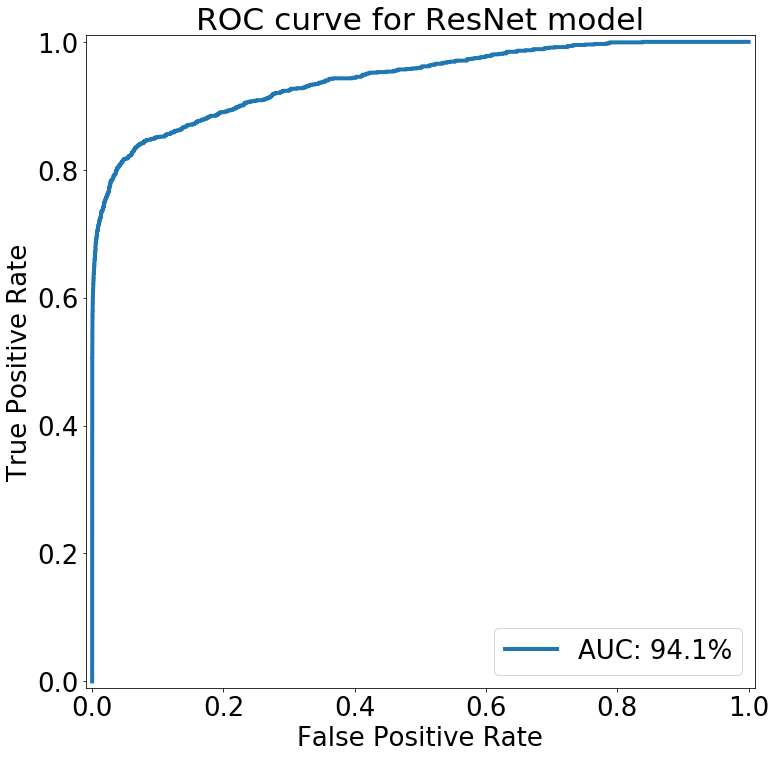

In [0]:
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import os
import matplotlib
from scipy import interp

font = {'family' : 'normal',
        'size'   : 26}

matplotlib.rc('font', **font)

base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(12,12))
score_per = score*100
fpr, tpr, thresholds = roc_curve(y_test, preds)
plt.plot(fpr,tpr, linewidth=4)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.title("ROC curve for ResNet model")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(["AUC: %.1f%%" % score_per],loc = 'lower right')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


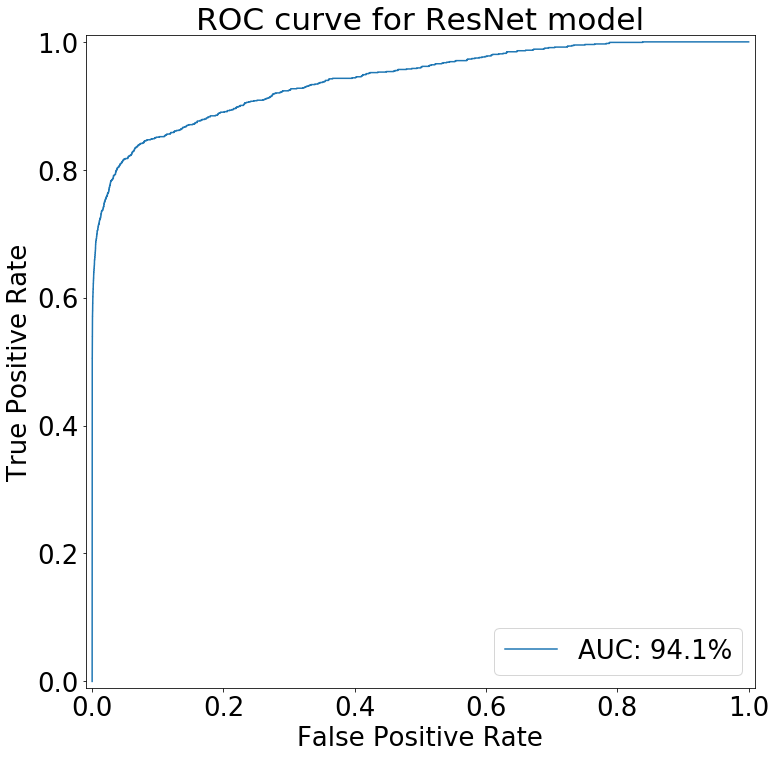

In [0]:
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import os
import matplotlib
from scipy import interp

font = {'family' : 'normal',
        'size'   : 26}

matplotlib.rc('font', **font)

base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(12,12))
score_per = score*100
fpr, tpr, thresholds = roc_curve(y_test, preds)
plt.plot(fpr,tpr)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.title("ROC curve for ResNet model")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(["AUC: %.1f%%" % score_per],loc = 'lower right')

In [0]:
index_thresh08 = np.amin(np.where(tpr>0.8))
index_thresh09 = np.amin(np.where(tpr>0.9))

In [0]:
positives = sum(y_test)
negatives = np.shape(preds)[0]- sum(y_test)
print(positives, negatives)
print(fpr[index_thresh08])
print(0.8*positives)
print(fpr[index_thresh08]*negatives)
print((fpr[index_thresh08]*negatives + 0.8*positives ) * 0.5/ 60 )
print(np.shape(preds)[0] * 0.5/ 3600 )
print(thresholds[index_thresh08])
print(0.8*positives*0.5 / 60)

1228 101487
0.03772897021293368
982.4000000000001
3829.0
40.095
14.265972222222222
0.91171414
8.186666666666667


In [0]:
print(0.9*positives)
print(fpr[index_thresh09])
print(fpr[index_thresh09]* np.shape(preds)[0])
print(thresholds[index_thresh09])

1105.2
0.22564466384857174
23177.091647206045
0.42364728


In [0]:
print((fpr[index_thresh09]*negatives + 0.9*positives ) * 0.5/ 3600 )
print(np.shape(preds)[0] * 0.5/ 3600 )

3.3340555555555556
14.265972222222222
